## Modulos necesarios

In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras.utils as image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

In [2]:
import numpy as np
from glob import glob

from tensorflow import keras
from tensorflow.keras.backend import max
from tensorflow.keras.metrics import BinaryAccuracy

from keras_unet_collection import models, base, utils

In [3]:
import keras.backend as K

# Extracción de imágenes

In [4]:
# Introduce parameters
img_row = 128
img_col = 128
img_chan = 1
epochnum = 100
batchnum = 16 
num_imgs = 780
input_size = (img_row, img_col, img_chan)

In [5]:
path = r'C:\Users\pedro\Documents\MASTER Pedro\Vision Artificial\M1_M2\archive\Dataset_BUSI_with_GT'

images = []
masks = []

for f_name in os.listdir(path):
    file_name = os.path.join(path,f_name)
    for name in os.listdir(file_name):
        file = os.path.join(file_name,name)
            
        if 'mask.' in file:
            tmp_mask = image.load_img(os.path.join(file_name, name), target_size=(img_row, img_col, img_chan))
            mask = image.img_to_array(tmp_mask)
            masks.append(mask[:,:,0]/255.0) 
            
        elif 'mask_' in file:
            tmp_mask = image.load_img(os.path.join(file_name, name), target_size=(img_row, img_col, img_chan))
            mask = image.img_to_array(tmp_mask)
            mask_final = masks[-1] + (mask[:,:,0]/255.0)
            masks.pop()
            masks.append(mask_final)
            
        else:
            tmp_img = image.load_img(os.path.join(file_name, name), target_size=(img_row, img_col, img_chan))
            img = image.img_to_array(tmp_img)
            images.append(img[:,:,0]/255.0) 

In [6]:
num_imgs = len(images)
imgs = np.zeros((num_imgs, img_row, img_col))
masks_ = np.zeros_like(imgs)

for i in range(num_imgs):
    imgs[i] = images[i]
    
for i in range(num_imgs):
    masks_[i] = masks[i]

# Métricas de evaluación y entrenamiento (DICE)

In [7]:
# Define loss and performance metrics
# Partially from Abraham and Khan (2019) - A Novel Focal Tversly Loss Function for Lesion Segmentation

# Dice score coefficient and Dice loss 
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

## Separación train y test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)

## Representación de train y validación

In [124]:
def Representacion(history,epochnum, batchnum):
    print('Training time: %s' % (now() - t))

    #Plot the loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['dsc'] 
    val_acc = history.history['val_dsc']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
    plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    
    plt.savefig('Graph_UNET.png')
    plt.show()

# U-NET

In [10]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

In [11]:
# Build the model
def Network():
    
    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = ConvBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = ConvBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = ConvBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = ConvBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model

In [12]:
model = Network()
model.compile(optimizer = Adam(lr = 0.0001), loss = dice_loss, metrics = [dsc])

C:\Users\pedro\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
t = now()

history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/100
28/28 [==============================] - 25s 835ms/step - loss: 0.8659 - dsc: 0.1352 - val_loss: 0.8545 - val_dsc: 0.1445
Epoch 2/100
28/28 [==============================] - 24s 867ms/step - loss: 0.8643 - dsc: 0.1376 - val_loss: 0.8495 - val_dsc: 0.1494
Epoch 3/100
28/28 [==============================] - 24s 859ms/step - loss: 0.8395 - dsc: 0.1619 - val_loss: 0.7336 - val_dsc: 0.2644
Epoch 4/100
28/28 [==============================] - 24s 848ms/step - loss: 0.6463 - dsc: 0.3576 - val_loss: 0.5094 - val_dsc: 0.4871
Epoch 5/100
28/28 [==============================] - 23s 809ms/step - loss: 0.5731 - dsc: 0.4204 - val_loss: 0.4980 - val_dsc: 0.4989
Epoch 6/100
28/28 [==============================] - 24s 843ms/step - loss: 0.5348 - dsc: 0.4699 - val_loss: 0.4847 - val_dsc: 0.5120
Epoch 7/100
28/28 [==============================] - 24s 859ms/step - loss: 0.5239 - dsc: 0.4715 - val_loss: 0.5145 - val_dsc: 0.4826
Epoch 8/100
28/28 [==============================] - 24s 862ms

Epoch 62/100
28/28 [==============================] - 24s 851ms/step - loss: 0.2071 - dsc: 0.7926 - val_loss: 0.3134 - val_dsc: 0.6858
Epoch 63/100
28/28 [==============================] - 22s 804ms/step - loss: 0.2148 - dsc: 0.7876 - val_loss: 0.3529 - val_dsc: 0.6466
Epoch 64/100
28/28 [==============================] - 22s 787ms/step - loss: 0.2050 - dsc: 0.7985 - val_loss: 0.2934 - val_dsc: 0.7063
Epoch 65/100
28/28 [==============================] - 22s 789ms/step - loss: 0.1978 - dsc: 0.7896 - val_loss: 0.2813 - val_dsc: 0.7185
Epoch 66/100
28/28 [==============================] - 22s 799ms/step - loss: 0.2148 - dsc: 0.7889 - val_loss: 0.3310 - val_dsc: 0.6692
Epoch 67/100
28/28 [==============================] - 22s 788ms/step - loss: 0.1907 - dsc: 0.8052 - val_loss: 0.2879 - val_dsc: 0.7124
Epoch 68/100
28/28 [==============================] - 22s 788ms/step - loss: 0.1862 - dsc: 0.8119 - val_loss: 0.2922 - val_dsc: 0.7080
Epoch 69/100
28/28 [==============================] - 2

In [14]:
# Make predictions
t = now()
preds_UNET = model.predict(X_test)
print('Testing time: %s' % (now() - t))

8/8 [==============================] - 2s 246ms/step
Testing time: 0:00:02.244636


Training time: 0:00:02.251617


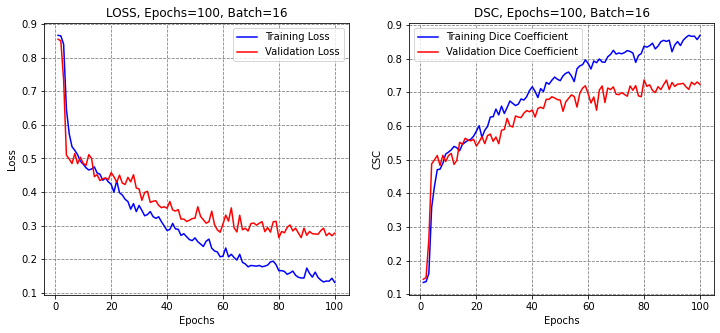

In [15]:
Representacion(history,epochnum, batchnum)

In [17]:
train_loss = history.history['loss']
epochsn = np.arange(1, len(train_loss)+1,1)
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_UNET.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.617 
 IOU 		0.541 
 Recall 	0.724 
 Precision	0.749
 Global Acc 	0.956
 AUC ROC 	0.862


************************************************************


# U-NET Dense

In [18]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [19]:
from keras.optimizers import *
from keras.models import *

def DenseUNet(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [20]:
model = DenseUNet()
t = now()

history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/100


C:\Users\pedro\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


28/28 [==============================] - 58s 2s/step - loss: 0.7975 - dsc: 0.2038 - val_loss: 0.8563 - val_dsc: 0.1427
Epoch 2/100
28/28 [==============================] - 55s 2s/step - loss: 0.6377 - dsc: 0.3581 - val_loss: 0.7699 - val_dsc: 0.2286
Epoch 3/100
28/28 [==============================] - 51s 2s/step - loss: 0.5278 - dsc: 0.4710 - val_loss: 0.7955 - val_dsc: 0.2028
Epoch 4/100
28/28 [==============================] - 51s 2s/step - loss: 0.4561 - dsc: 0.5484 - val_loss: 0.8313 - val_dsc: 0.1674
Epoch 5/100
28/28 [==============================] - 51s 2s/step - loss: 0.4227 - dsc: 0.5678 - val_loss: 0.8030 - val_dsc: 0.1951
Epoch 6/100
28/28 [==============================] - 51s 2s/step - loss: 0.3674 - dsc: 0.6372 - val_loss: 0.7813 - val_dsc: 0.2172
Epoch 7/100
28/28 [==============================] - 52s 2s/step - loss: 0.3168 - dsc: 0.6800 - val_loss: 0.8402 - val_dsc: 0.1589
Epoch 8/100
28/28 [==============================] - 51s 2s/step - loss: 0.3289 - dsc: 0.6721 -

In [21]:
# Make predictions
t = now()
preds_Dense = model.predict(X_test)
print('Testing time: %s' % (now() - t))

8/8 [==============================] - 6s 611ms/step
Testing time: 0:00:05.763657


Training time: 0:00:05.770639


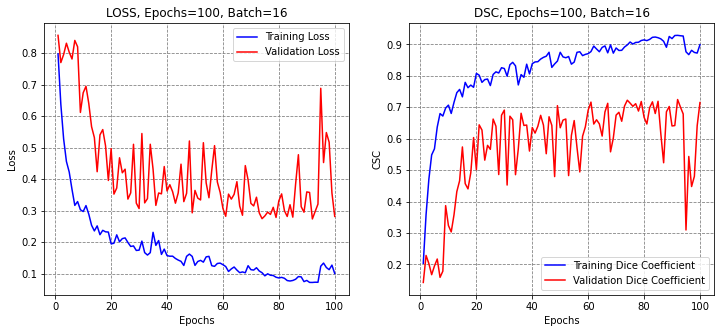

In [22]:
Representacion(history,epochnum,batchnum)

In [35]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Dense[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Dense.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.642 
 IOU 		0.562 
 Recall 	0.773 
 Precision	0.732
 Global Acc 	0.951
 AUC ROC 	0.823


************************************************************


# Attention U-NET

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)

X_train = tf.convert_to_tensor(X_train)
X_train = tf.reshape(X_train, [X_train.shape[0],X_train.shape[1],X_train.shape[2],1])

X_test = tf.convert_to_tensor(X_test)
X_test = tf.reshape(X_test, [X_test.shape[0],X_test.shape[1],X_test.shape[2],1])

Y_train = tf.convert_to_tensor(Y_train)
Y_train = tf.reshape(Y_train, [Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1])

Y_test = tf.convert_to_tensor(Y_test)
Y_test = tf.reshape(Y_test, [Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1])

In [25]:
from keras_unet_collection._model_att_unet_2d import att_unet_2d

model = att_unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=1, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool='max', unpool=False,  
                           name='attunet')

In [26]:
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=dsc)
import datetime
now = datetime.datetime.now
t = now()

history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/100
28/28 [==============================] - 127s 4s/step - loss: 0.7380 - dsc: 0.2616 - val_loss: 0.8579 - val_dsc: 0.1411
Epoch 2/100
28/28 [==============================] - 122s 4s/step - loss: 0.5870 - dsc: 0.4055 - val_loss: 0.8634 - val_dsc: 0.1357
Epoch 3/100
28/28 [==============================] - 122s 4s/step - loss: 0.5004 - dsc: 0.4944 - val_loss: 0.8688 - val_dsc: 0.1304
Epoch 4/100
28/28 [==============================] - 122s 4s/step - loss: 0.4844 - dsc: 0.5056 - val_loss: 0.8774 - val_dsc: 0.1219
Epoch 5/100
28/28 [==============================] - 123s 4s/step - loss: 0.4325 - dsc: 0.5677 - val_loss: 0.8862 - val_dsc: 0.1132
Epoch 6/100
28/28 [==============================] - 123s 4s/step - loss: 0.4184 - dsc: 0.5795 - val_loss: 0.9055 - val_dsc: 0.0940
Epoch 7/100
28/28 [==============================] - 122s 4s/step - loss: 0.3621 - dsc: 0.6348 - val_loss: 0.9177 - val_dsc: 0.0819
Epoch 8/100
28/28 [==============================] - 121s 4s/step - loss: 0.

In [27]:
# Make predictions
t = now()
preds_Att = model.predict(X_test)
print('Testing time: %s' % (now() - t))

8/8 [==============================] - 14s 2s/step
Testing time: 0:00:14.090530


Training time: 0:00:14.099505


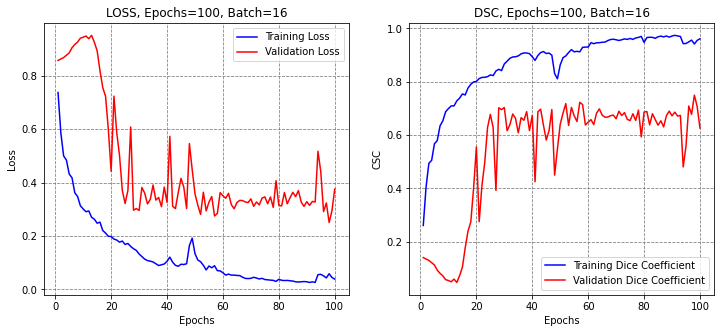

In [28]:
Representacion(history,epochnum,batchnum)

In [36]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Att[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Dense.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Att.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.628 
 IOU 		0.565 
 Recall 	0.615 
 Precision	0.893
 Global Acc 	0.951
 AUC ROC 	0.929


************************************************************


# U-NET Dense + Attended

In [86]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def Attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)
 
    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)
    
    w = Add()([Wg,Ws])
 
    out = Activation("relu")(w)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)
    return Multiply()([out,s])

In [87]:
from keras.optimizers import *
from keras.models import *

def DenseUNet_AttGate(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    Att3 = Attention_gate(conv3,deconv3,start_neurons * 4)  
    uconv3 = concatenate([deconv3, Att3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    Att2 = Attention_gate(conv2,deconv2,start_neurons * 2)  
    uconv2 = concatenate([deconv2, Att2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    Att1 = Attention_gate(conv1,deconv1,start_neurons * 1)  
    uconv1 = concatenate([deconv1, Att1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [88]:
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
model2 = DenseUNet_AttGate()

C:\Users\pedro\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [89]:
t = now()

history = model2.fit(X_train, Y_train, validation_split=0.2, batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/100
28/28 [==============================] - 66s 2s/step - loss: 0.7594 - dsc: 0.2432 - val_loss: 0.8312 - val_dsc: 0.1676
Epoch 2/100
28/28 [==============================] - 61s 2s/step - loss: 0.6341 - dsc: 0.3701 - val_loss: 0.8820 - val_dsc: 0.1173
Epoch 3/100
28/28 [==============================] - 58s 2s/step - loss: 0.5720 - dsc: 0.4226 - val_loss: 0.9036 - val_dsc: 0.0959
Epoch 4/100
28/28 [==============================] - 58s 2s/step - loss: 0.4947 - dsc: 0.5058 - val_loss: 0.9270 - val_dsc: 0.0727
Epoch 5/100
28/28 [==============================] - 57s 2s/step - loss: 0.4301 - dsc: 0.5695 - val_loss: 0.9659 - val_dsc: 0.0341
Epoch 6/100
28/28 [==============================] - 57s 2s/step - loss: 0.3983 - dsc: 0.6015 - val_loss: 0.8663 - val_dsc: 0.1337
Epoch 7/100
28/28 [==============================] - 58s 2s/step - loss: 0.3373 - dsc: 0.6628 - val_loss: 0.9572 - val_dsc: 0.0423
Epoch 8/100
28/28 [==============================] - 57s 2s/step - loss: 0.3218 - d

In [90]:
# Make predictions
t = now()
preds_DA = model2.predict(X_test)
print('Testing time: %s' % (now() - t))

8/8 [==============================] - 7s 708ms/step
Testing time: 0:00:06.633347


Training time: 0:00:06.651298


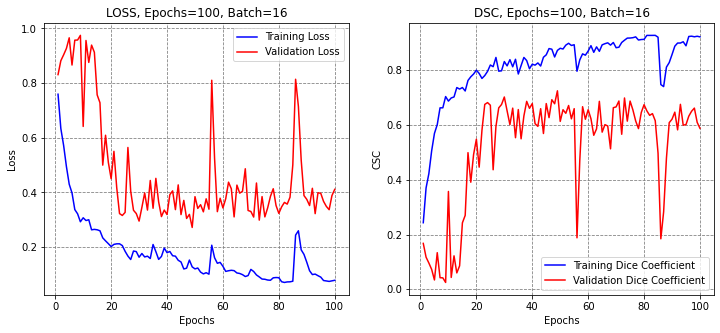

In [91]:
Representacion(history,epochnum,batchnum)

In [92]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_DA[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_DA.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.613 
 IOU 		0.551 
 Recall 	0.600 
 Precision	0.919
 Global Acc 	0.953
 AUC ROC 	0.921


************************************************************


# U-NET 3+

In [40]:
model = models.unet_3plus_2d(input_size, n_labels=1, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=False, name='unet3plus')

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256


In [41]:
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[dsc])

import datetime
now = datetime.datetime.now
t = now()

history = model.fit(X_train, Y_train, validation_split=0.2, batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/100
28/28 [==============================] - 200s 7s/step - loss: 0.7171 - dsc: 0.2842 - val_loss: 0.8661 - val_dsc: 0.1330
Epoch 2/100
28/28 [==============================] - 179s 6s/step - loss: 0.5050 - dsc: 0.5012 - val_loss: 0.8930 - val_dsc: 0.1064
Epoch 3/100
28/28 [==============================] - 180s 6s/step - loss: 0.4162 - dsc: 0.5817 - val_loss: 0.9221 - val_dsc: 0.0776
Epoch 4/100
28/28 [==============================] - 180s 6s/step - loss: 0.3676 - dsc: 0.6215 - val_loss: 0.9583 - val_dsc: 0.0416
Epoch 5/100
28/28 [==============================] - 180s 6s/step - loss: 0.3230 - dsc: 0.6804 - val_loss: 0.9805 - val_dsc: 0.0195
Epoch 6/100
28/28 [==============================] - 181s 6s/step - loss: 0.3052 - dsc: 0.6969 - val_loss: 0.9878 - val_dsc: 0.0122
Epoch 7/100
28/28 [==============================] - 181s 6s/step - loss: 0.2783 - dsc: 0.7166 - val_loss: 0.9939 - val_dsc: 0.0061
Epoch 8/100
28/28 [==============================] - 183s 7s/step - loss: 0.

In [42]:
# Make predictions
t = now()
preds_3p = model.predict(X_test)
print('Testing time: %s' % (now() - t))

8/8 [==============================] - 20s 2s/step
Testing time: 0:00:19.654105


Training time: 0:00:19.663176


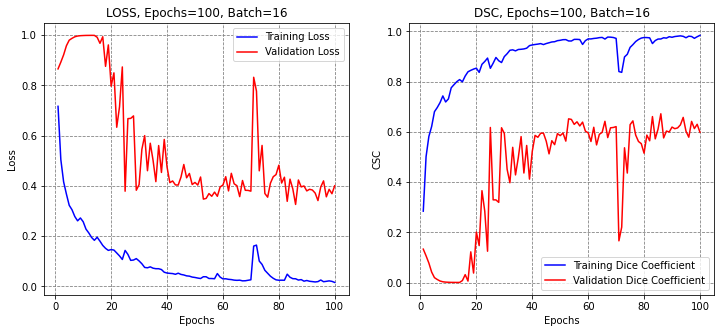

In [43]:
Representacion(history,epochnum,batchnum)

In [46]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_3p[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_3p.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_3p.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

------------------------------
USING THRESHOLD 0.5

 DSC 		0.632 
 IOU 		0.560 
 Recall 	0.614 
 Precision	0.883
 Global Acc 	0.953
 AUC ROC 	0.934


************************************************************


# Representación de las mascaras 

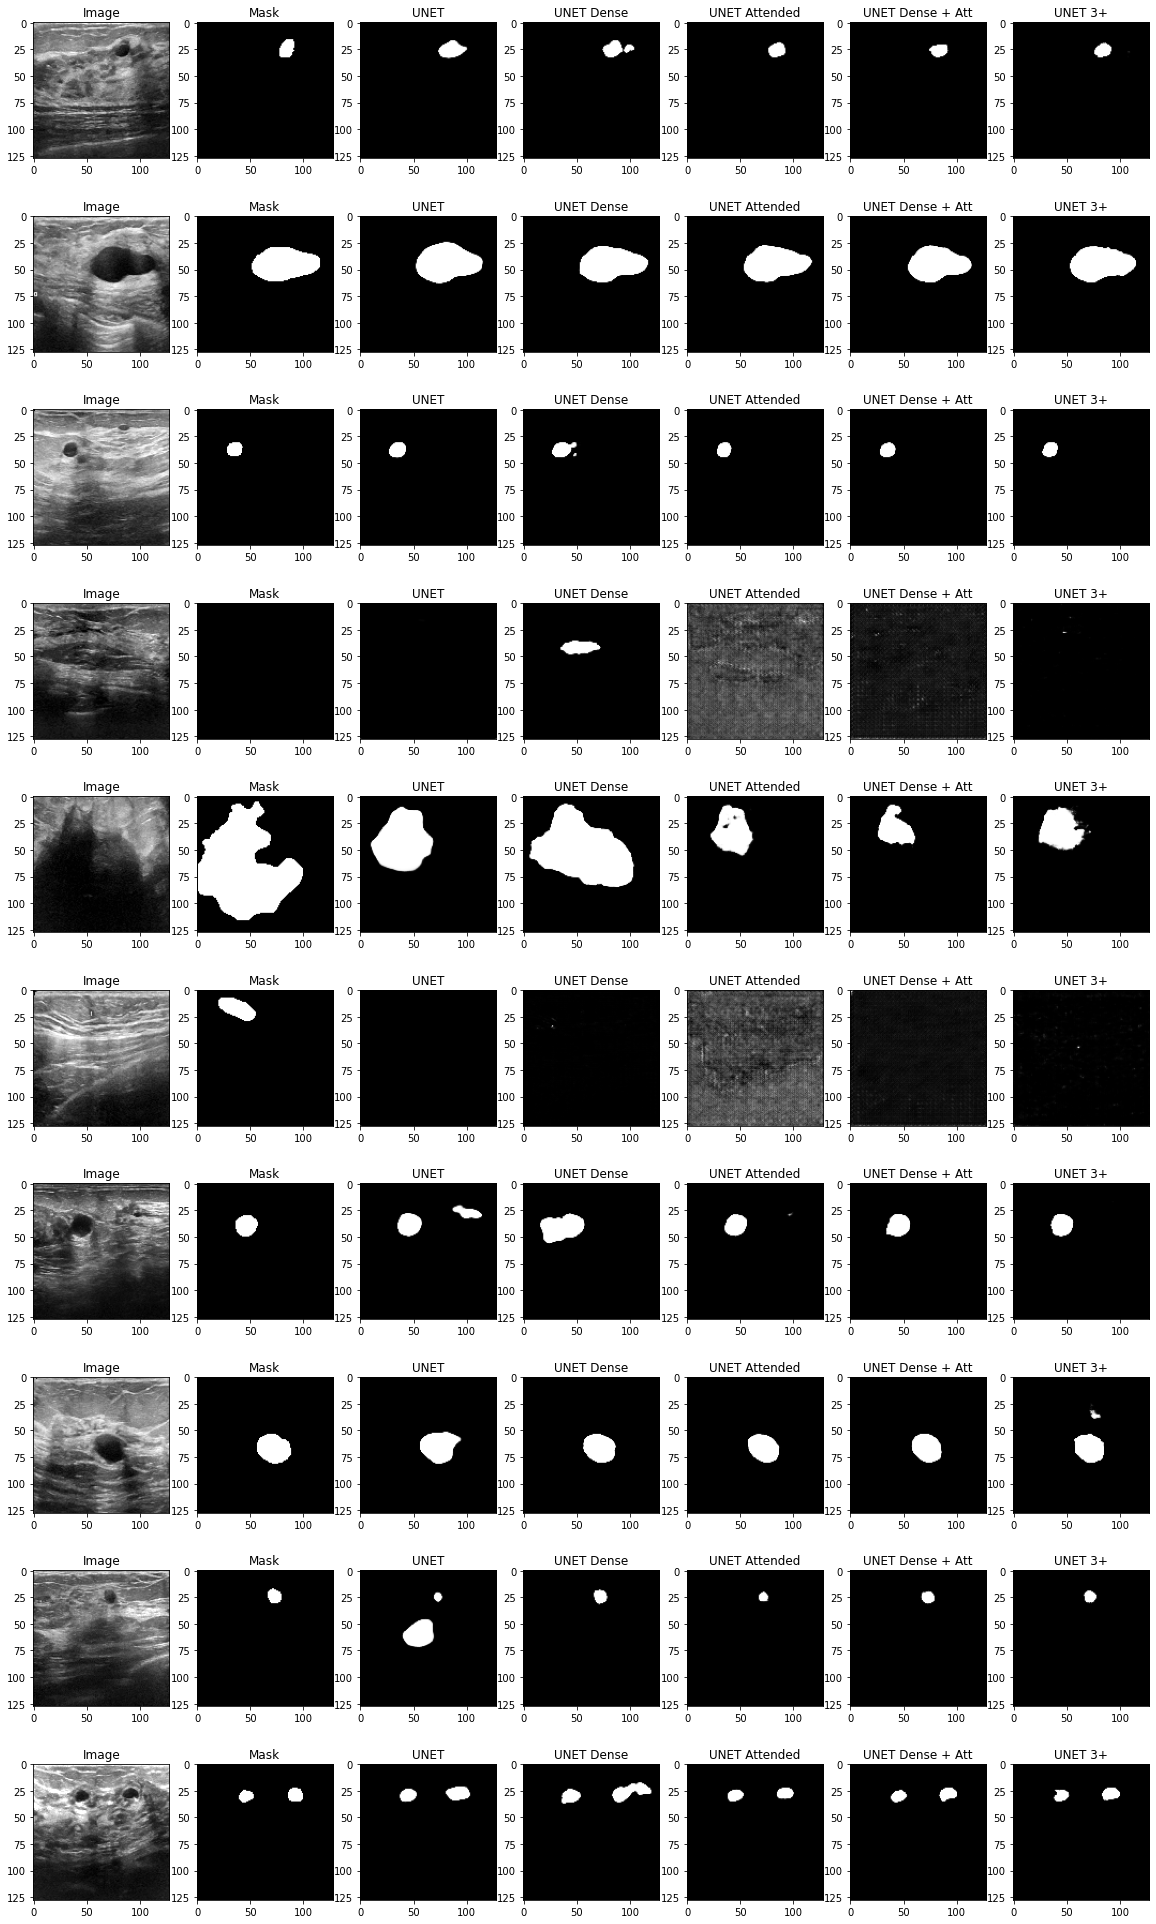

In [123]:
# To plot a set of images with predicted masks uncomment these lines
j = 0
import random
n1 = random.randint(0,len(X_test)-1)
n2 = random.randint(0,len(X_test)-1)
n3 = random.randint(0,len(X_test)-1)
n4 = random.randint(0,len(X_test)-1)
n5 = random.randint(0,len(X_test)-1)
n6 = random.randint(0,len(X_test)-1)
n7 = random.randint(0,len(X_test)-1)
n8 = random.randint(0,len(X_test)-1)
n9 = random.randint(0,len(X_test)-1)
n10 = random.randint(0,len(X_test)-1)

num_disp = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n10]
j=1
plt.figure(figsize = (20,35))
for i in num_disp:
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(X_test[i]), cmap='gray')
    plt.title('Image')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(Y_test[i]),cmap='gray')
    plt.title('Mask')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_UNET[i]),cmap='gray')
    plt.title('UNET')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Dense[i]),cmap='gray')
    plt.title('UNET Dense')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Att[i]),cmap='gray')
    plt.title('UNET Attended')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_DA[i]),cmap='gray')
    plt.title('UNET Dense + Att')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_3p[i]),cmap='gray')
    plt.title('UNET 3+')
    j +=1
    

plt.savefig('Masks.png')
plt.show()